## You can use this Notebook to visualize images sample of the training Data
conda create --name PPHAU python=3.10  
conda activate PPHAU   
conda install opencv numpy matplotlib           

In [1]:
# ONLY RUN GOOGLE COLAB, Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# ONLY RUN THIS ON GOOGLE COLAB.
cd /content/drive/MyDrive/'Colab Notebooks/human-activity-understanding/HW2'

/content/drive/MyDrive/Colab Notebooks/human-activity-understanding/HW2


In [4]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
# Define data folder
TRAIN_IMAGES_DIR = 'data/train_images'
TRAIN_LABELS_DIR = os.path.join(TRAIN_IMAGES_DIR, 'labels')

In [5]:

def parse_yolo_label(label_path, img_width, img_height):
    """
    Parses a YOLO format segmentation label file and returns a list of masks.
    Each mask is returned as (class_id, polygon_points) where polygon_points is a list of (x, y) tuples in pixel coordinates.
    """
    masks = []
    if not os.path.exists(label_path):
        print(f"Warning: Label file not found: {label_path}")
        return masks

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 3: # Must have at least class_id, x1, y1
                class_id = int(parts[0])
                polygon_normalized = list(map(float, parts[1:]))

                # Convert normalized coordinates to pixel coordinates
                polygon_points = []
                for i in range(0, len(polygon_normalized), 2):
                    x = int(polygon_normalized[i] * img_width)
                    y = int(polygon_normalized[i+1] * img_height)
                    polygon_points.append((x, y))
                masks.append((class_id, polygon_points))
    return masks

def draw_bboxes_and_labels(image, masks, classes):
    """
    Draws segmentation masks and class labels on an image with semi-transparent colors.
    """
    img_copy = image.copy()
    overlay = img_copy.copy()
    alpha = 0.4  # Transparency factor

    # Define a set of distinct colors for classes (BGR format for OpenCV)
    class_colors = [
        (0, 0, 155),    # Red for class 0 (person)
        (0, 155, 0),    # Green for class 1 (table)
        (155, 0, 0),    # Blue for class 2 (leg)
        (0, 155, 155),  # Yellow for class 3 (tool1)
        (155, 0, 155)   # Magenta for class 4 (tool2)
    ]

    for class_id, polygon_points in masks:
        if polygon_points:
            # Get color for the class
            color = class_colors[class_id % len(class_colors)] if class_id < len(class_colors) else (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) # Fallback random color

            # Reshape points for cv2.fillPoly and cv2.polylines
            pts = np.array(polygon_points, np.int32)
            pts = pts.reshape((-1, 1, 2))

            # Fill the polygon on the overlay with semi-transparency
            cv2.fillPoly(overlay, [pts], color)

            # Draw polygon outline
            cv2.polylines(img_copy, [pts], True, color, 2)

            # Put label
            label = classes[class_id] if class_id < len(classes) else f"Unknown Class {class_id}"
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.7
            font_thickness = 2
            text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]

            # Place text near the first point of the polygon
            text_x = polygon_points[0][0]
            text_y = polygon_points[0][1] - 10 if polygon_points[0][1] - 10 > text_size[1] else polygon_points[0][1] + text_size[1] + 10

            # Draw background for text
            cv2.rectangle(img_copy, (text_x, text_y - text_size[1] - 5),
                          (text_x + text_size[0] + 5, text_y + 5), color, -1)
            cv2.putText(img_copy, label, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)

    # Combine the original image with the overlay using the transparency factor
    img_with_masks = cv2.addWeighted(overlay, alpha, img_copy, 1 - alpha, 0)
    return img_with_masks

print("Modified helper functions `parse_yolo_label` and `draw_bboxes_and_labels` to handle segmentation masks with semi-transparent class-specific colors.")

Modified helper functions `parse_yolo_label` and `draw_bboxes_and_labels` to handle segmentation masks with semi-transparent class-specific colors.


Visualizing 3 random images...


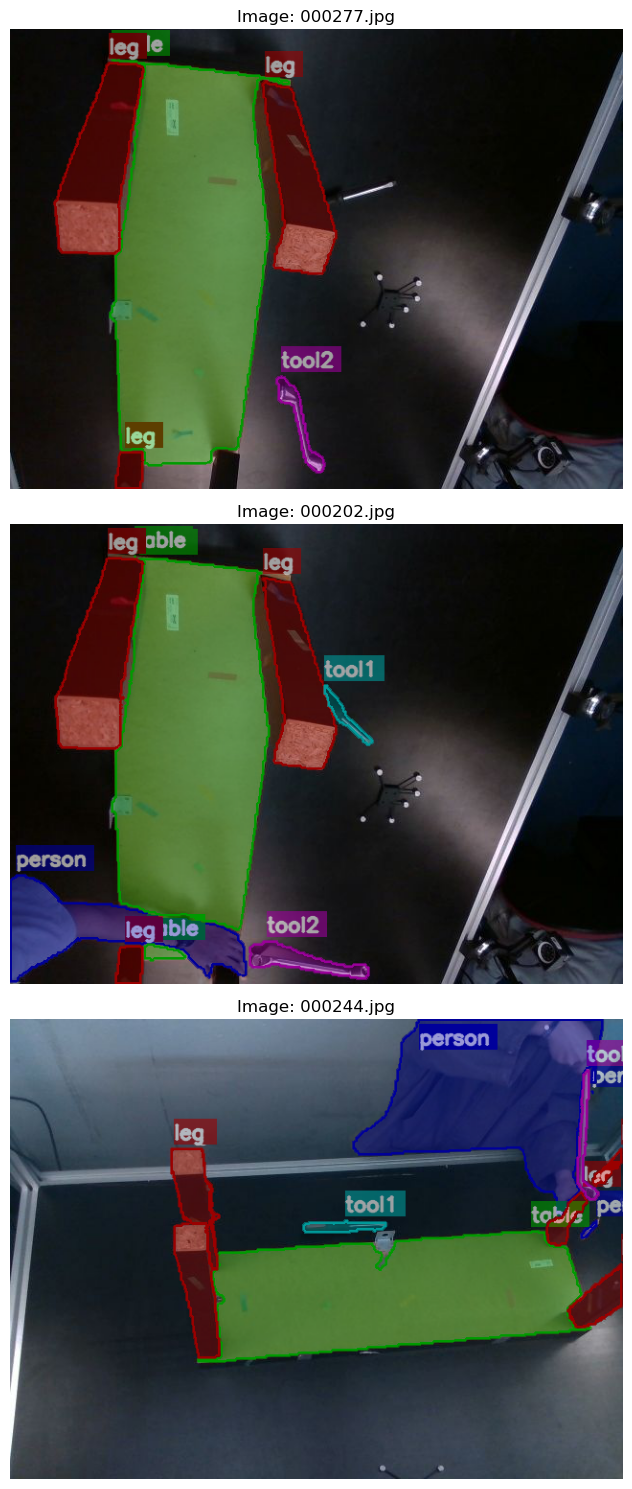

Finished visualizing 3 images with bounding boxes.


In [20]:
CLASSES = ['person','table', 'leg','tool1', 'tool2']
# Get a list of all image files in the new training directory
train_image_files = [f for f in os.listdir(TRAIN_IMAGES_DIR) if f.lower().endswith(('.jpg', '.jpeg'))]

# Randomly select 3 images to visualize
num_images_to_visualize = min(3, len(train_image_files)) # Ensure we don't try to visualize more than available
selected_images_for_viz = random.sample(train_image_files, num_images_to_visualize)

print(f"Visualizing {num_images_to_visualize} random images...")

plt.figure(figsize=(15, 5 * num_images_to_visualize))

for i, img_filename in enumerate(selected_images_for_viz):
    img_path = os.path.join(TRAIN_IMAGES_DIR, img_filename)
    label_filename = os.path.splitext(img_filename)[0] + '.txt'
    label_path = os.path.join(TRAIN_LABELS_DIR, label_filename)

    # Read the image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image: {img_path}")
        continue

    # OpenCV reads images as BGR, convert to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_height, img_width, _ = img_rgb.shape

    # Parse YOLO labels
    bboxes = parse_yolo_label(label_path, img_width, img_height)

    # Draw bounding boxes and labels
    img_with_boxes = draw_bboxes_and_labels(img_rgb, bboxes, CLASSES)

    # Display the image
    plt.subplot(num_images_to_visualize, 1, i + 1)
    plt.imshow(img_with_boxes)
    plt.title(f"Image: {img_filename}")
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Finished visualizing {num_images_to_visualize} images with bounding boxes.")